# Tallado de costuras para cambiar el tamaño de la imagen según el contenido

En este cuaderno de procesamiento de imágenes veremos un algoritmo para
reescalar una imagen de manera que se ajuste a su contenido.
Este algoritmo es relativamente nuevo, pero tan simple y efectivo que ahora se
considera un ejercicio común en los cursos de procesamiento de imágenes y
algoritmia.

In [1]:
import skimage as ski
from scipy import signal
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

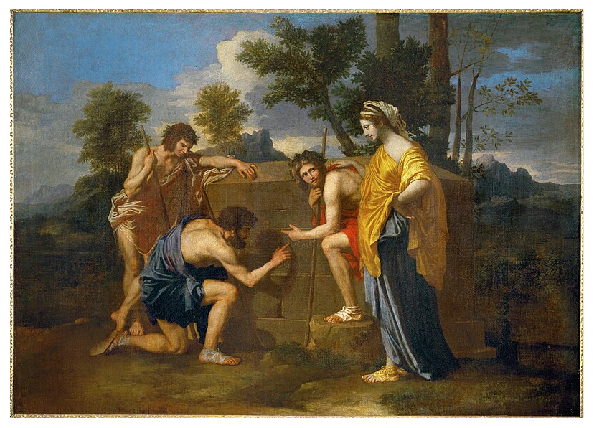

In [2]:
imagen = ski.io.imread("pinturas/Nicolas_Poussin_-_Et_in_Arcadia_ego_(deuxième_version).jpg")

fig, ax = plt.subplots()
ski.io.imshow(imagen, ax=ax)
ax.set_axis_off()

La *energía* de un píxel es una medida de cuán diferente es de sus vecinos, es
decir, qué tan notorio o importante es el píxel en la imagen.
El algoritmo de tallado de costuras se basa en la eliminación de los píxeles
con menor energía, de manera que la imagen se reescala sin perder los detalles
más importantes.

Existen muchas definiciones formales de energía, pero en este cuaderno usanremos
la energía de *Sobel*, que es una medida de la variación de la intensidad de los
píxeles vecinos.
Usualmente el filtro de Sobel se aplica a la imagen en escala de grises para
detectar bordes, pero en este caso se aplicará a cada canal de color por
separado para obtener la energía de cada píxel en cada canal.

Formalmente, el filtro de Sobel es una convolución de la imagen con dos
kernels, uno para la dirección horizontal y otro para la dirección vertical.
Estos kernels son los siguientes:

$$\begin{align*}
K_x &= \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix} \\
K_y &= \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
\end{align*}$$

Si *I* es una imagen en escala de gris, entonces el filtro de Sobel se aplica
de la siguiente manera para obtener una imagen de gradiente *G*:

$$\begin{align*}
G_x &= I * K_x \\
G_y &= I * K_y \\
G &= \sqrt{G_x^2 + G_y^2}
\end{align*}$$

Aquí, hemos usado el operador $*$ para denotar la convolución de la imagen con
el kernel.
Por lo tanto, al aplicar el filtro de Sobel a cada canal de color por separado,
obtenemos tres componentes de gradiente, $G_{r}$, $G_{g}$ y $G_{b}$.
Definimos la energía de un píxel como la norma euclidiana de estos gradientes:

$$E = \sqrt{G_{r}^2 + G_{g}^2 + G_{b}^2}$$

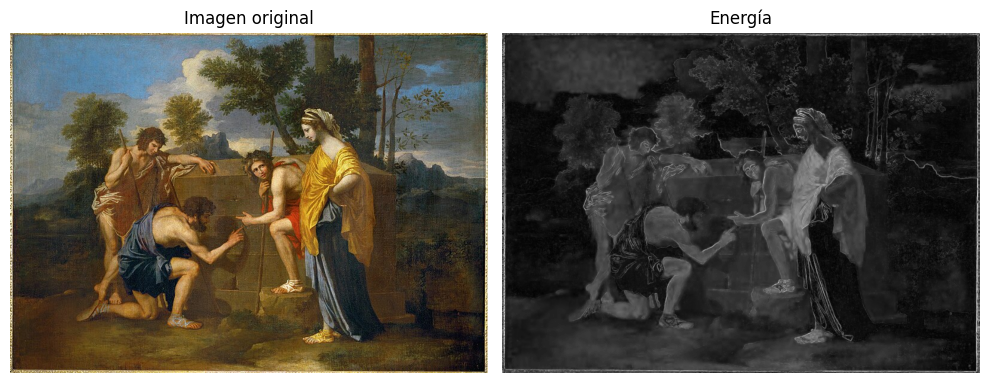

In [3]:
def energia(imagen: npt.NDArray[np.floating]) -> npt.NDArray[np.floating]:
    """Determina la energía de cada pixel de la imagen.
    
    La energía es qué tan distinto es un pixel de sus vecinos.
    """
    # Usamos un filtro de Sobel para calcular la energía
    capa_sobel = ski.filters.sobel(imagen)
    # La energía es la norma L2 de los gradientes
    capa_energia = np.linalg.norm(capa_sobel, axis=-1)
    return capa_energia

capa_energia = energia(imagen)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(imagen)
ax[0].set_title("Imagen original")
ax[0].axis("off")
ax[1].imshow(capa_energia, cmap="gray")
ax[1].set_title("Energía")
ax[1].axis("off")
fig.tight_layout()

Ahora que tenemos la matriz $E$ de energía de la imagen podemos proceder a
construir las costuras que serán eliminadas para reescalar la imagen.
Para esto, se construyen dos matrices auxiliares, $M$ y $P$ que determinan
respectivamente la mínima energía de una costura que llega a cada píxel y el
píxel anterior en la costura.

Las matrices $M$ y $P$ se construyen recursivamente, de arriva hacía abajo, de
la siguiente manera:

$$\begin{align*}
M(0, j) &= E(0, j) \\
P(0, j) &= -1 \\
P(i, j) &= \arg\min_{k \in \{-1, 0, 1\}} M(i-1, j+k) \\
M(i, j) &= E(i, j) + M(i-1, j + P(i, j))
\end{align*}$$

In [4]:
from typing import Iterator


def costuras(
    imagen: npt.NDArray[np.floating],
) -> tuple[npt.NDArray[np.floating], npt.NDArray[np.int8]]:
    """Calcula el costo de las costuras verticales de la imagen.

    Parámetros
    ----------
    imagen: np.ndarray
        Imagen de entrada.

    Retorna
    -------
    tuple[np.ndarray, np.ndarray]
        Costo de las costuras verticales y las direcciones de las costuras.
    """

    def costo_direccion(k: int) -> float:
        return costo[i - 1, j + k]

    def direcciones_viables(j: int) -> Iterator[int]:
        if j > 0:
            yield -1
        yield 0
        if j < n - 1:
            yield 1

    m, n = imagen.shape[:2]
    capa_energia = energia(imagen)
    # Inicializamos el costo de las costuras con la energía
    costo = capa_energia.copy()
    # Inicializamos la matriz de direcciones
    direcciones = np.zeros_like(costo, dtype=np.int8)

    # Calculamos el costo de las costuras mediante programación dinámica
    for i in range(1, m):
        for j in range(n):
            candidatos = direcciones_viables(j)
            direcciones[i, j] = min(candidatos, key=costo_direccion)
            costo[i, j] += costo_direccion(direcciones[i, j])

    return costo, direcciones

Con las matrices $M$ y $P$ construidas, se puede encontrar la costura de menor
energía simplemente buscando el píxel con menor energía acumulada en la última
fila de la matriz $M$ y, a partir de este, siguiendo los píxeles anteriores
en la matriz $P$.

In [5]:
def obtener_costura(
    costo: npt.NDArray[np.floating],
    direcciones: npt.NDArray[np.integer],
    j: int | None = None,
) -> npt.NDArray[np.integer]:
    """Calcula la costura vertical de menor costo.

    Parámetros
    ----------
    costo: np.ndarray
        Costo de las costuras verticales.
    direcciones: np.ndarray
        Direcciones de las costuras.
    j: int, opcional
        Columna inicial de la costura. Si no se especifica, se elige la
        de menor costo.

    Retorna
    -------
    np.ndarray
        Índices de las filas de la costura vertical.
    """
    m, n = costo.shape
    if j is None:
        j = np.argmin(costo[-1])
    costura = np.zeros(m, dtype=np.int_)
    for i in range(m - 1, -1, -1):
        costura[i] = j
        j += direcciones[i, j]
    return costura


In [6]:
def descocer(imagen: npt.NDArray[np.floating], costura: npt.NDArray[np.integer]) -> npt.NDArray[np.floating]:
    """Elimina una costura de la imagen.

    Parámetros
    ----------
    imagen: np.ndarray
        Imagen de entrada.
    costura: np.ndarray
        Índices de las filas de la costura vertical.

    Retorna
    -------
    np.ndarray
        Imagen sin la costura.
    """
    m, n = imagen.shape[:2]
    nueva_imagen = np.zeros((m, n - 1, 3), dtype=imagen.dtype)
    for i in range(m):
        nueva_imagen[i, :, :] = np.delete(imagen[i], costura[i], axis=0)
    return nueva_imagen

En nuestro ejemplo, la costura de menor energía es la siguiente:

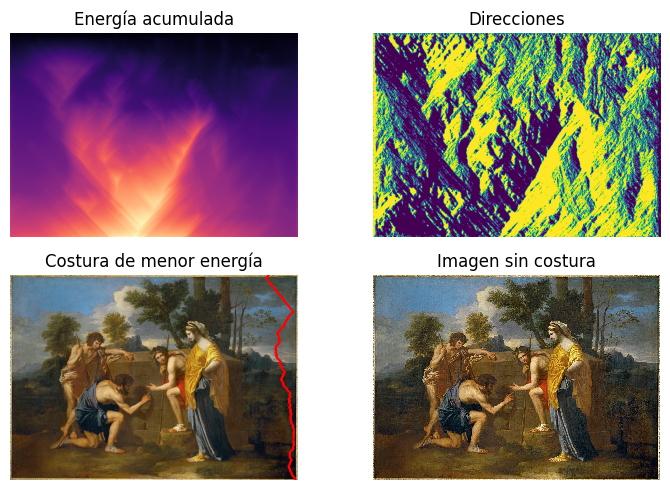

In [7]:
costo, direcciones = costuras(imagen)
costura = obtener_costura(costo, direcciones)
imagen_1 = descocer(imagen, costura)

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
# Graficar la matriz de costos (energía acumulada)
ax[0,0].imshow(costo, cmap="magma")
ax[0,0].set_title("Energía acumulada")
# Graficar las direcciones de las costuras
ax[0,1].imshow(direcciones, cmap="viridis")
ax[0,1].set_title("Direcciones")
# Graficar la costura encontrada
ax[1,0].imshow(imagen)
ax[1,0].plot(costura, range(imagen.shape[0]), color="red")
ax[1,0].set_title("Costura de menor energía")
# Graficar la imagen sin la costura
ski.io.imshow(imagen_1, ax=ax[1,1])
ax[1,1].set_title("Imagen sin costura")
for a in ax.flat:
    a.axis("off")
fig.tight_layout()


100%|██████████| 80/80 [03:07<00:00,  2.35s/it]


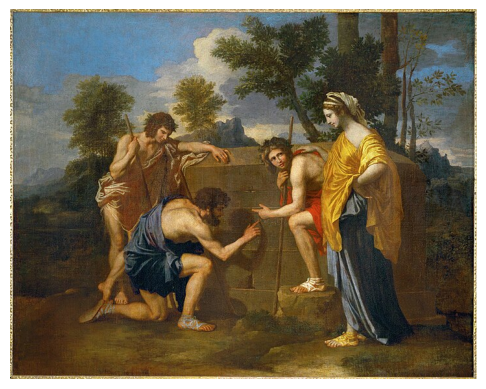

In [8]:
# Remover 10% de las columnas de menor energía
n_costuras = round(imagen.shape[1] * 0.1)
import tqdm

imagen_descocida = imagen.copy()
for _ in tqdm.trange(n_costuras):
    costo, direcciones = costuras(imagen_descocida)
    costura = obtener_costura(costo, direcciones)
    imagen_descocida = descocer(imagen_descocida, costura)

fig, ax = plt.subplots()
ax.imshow(imagen_descocida)
ax.axis("off")
plt.show()    
